In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import json
import pickle

In [270]:
df = pd.read_csv('data/train.csv')
df.shape

(1628, 29)

In [271]:
df.columns

Index(['Id', 'Age', 'Attrition', 'BusinessTravel', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'CommunicationSkill',
       'Behaviour'],
      dtype='object')

### Feature Engineering

In [272]:
def extract_feature(df_input):
    df = df_input.copy()
    df['PropWkngYrsToCompanies'] = pd.cut((df.TotalWorkingYears / (df.NumCompaniesWorked+1)),[-1,2,4,6,8,np.inf], labels=[1,2,3,4,5]).astype('int64')
    df['PropCurrMgrCompYears'] = df.YearsWithCurrManager / (df.YearsAtCompany+1)
    df['PropCurrRoleCompYears'] = df.YearsInCurrentRole / (df.YearsAtCompany+1)
    df['AgeCut'] = pd.cut(df.Age,bins = [0,25,35,50,np.inf], labels= [1,2,3,4]).astype('int64')
    df['Stocks'] = df.StockOptionLevel.apply(lambda x: 0 if x == 0 else 1)
    cols_to_drop = [
                'Id',
                'Behaviour', 
                'Gender',
                'Education',
                'Department',
                'StockOptionLevel',
                'Age',
                'PerformanceRating',
                'TrainingTimesLastYear', 
                'YearsInCurrentRole', 
                'YearsSinceLastPromotion', 
                'YearsWithCurrManager',
                'NumCompaniesWorked',
                'TotalWorkingYears',
                'PercentSalaryHike',
                'MaritalStatus',
                'EducationField',
                'YearsAtCompany'
                ]
    df.drop(cols_to_drop, inplace = True, axis = 1)
    print('Columns Dropped : {}'.format(cols_to_drop))
    print('Columns in DataFrame: {}'.format(df.columns.to_list()))
    return df

In [273]:
df_cleaned = extract_feature(df)

Columns Dropped : ['Id', 'Behaviour', 'Gender', 'Education', 'Department', 'StockOptionLevel', 'Age', 'PerformanceRating', 'TrainingTimesLastYear', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumCompaniesWorked', 'TotalWorkingYears', 'PercentSalaryHike', 'MaritalStatus', 'EducationField', 'YearsAtCompany']
Columns in DataFrame: ['Attrition', 'BusinessTravel', 'DistanceFromHome', 'EmployeeNumber', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MonthlyIncome', 'OverTime', 'CommunicationSkill', 'PropWkngYrsToCompanies', 'PropCurrMgrCompYears', 'PropCurrRoleCompYears', 'AgeCut', 'Stocks']


### Preprocessing and Model Building Init

In [274]:
#df_cleaned.drop_duplicates(inplace=True)
df_cleaned.shape

(1628, 16)

In [275]:
df_X = df_cleaned.drop(['Attrition'], axis = 1).copy()
df_y = df_cleaned[['Attrition']].copy()

In [276]:
object_type = df_X.select_dtypes(include='object').columns
object_type

numerical_type = df_X.select_dtypes(exclude='object').columns
numerical_type

cat_cols = []
for c in object_type:
    cat_cols.append(df_X.columns.to_list().index(c))
    
cat_cols

[0, 5, 8]

In [277]:
df_X.head()

,BusinessTravel,DistanceFromHome,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobRole,JobSatisfaction,MonthlyIncome,OverTime,CommunicationSkill,PropWkngYrsToCompanies,PropCurrMgrCompYears,PropCurrRoleCompYears,AgeCut,Stocks
0,Non-Travel,2,571,3,3,Laboratory Technician,4,2564,No,4,5,0.583333,0.583333,2,0
1,Travel_Rarely,12,1614,3,3,Manufacturing Director,3,4663,Yes,2,1,0.250000,0.500000,3,1
2,Travel_Rarely,2,842,3,3,Sales Executive,4,5160,No,5,2,0.300000,0.700000,4,0
3,Travel_Rarely,24,2014,1,3,Research Scientist,4,4108,No,4,2,0.875000,0.875000,3,0
4,Travel_Rarely,3,689,3,3,Manufacturing Director,3,9434,No,1,3,0.727273,0.636364,3,1


In [278]:
df_X.dtypes

BusinessTravel              object
DistanceFromHome             int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
JobInvolvement               int64
JobRole                     object
JobSatisfaction              int64
MonthlyIncome                int64
OverTime                    object
CommunicationSkill           int64
PropWkngYrsToCompanies       int64
PropCurrMgrCompYears       float64
PropCurrRoleCompYears      float64
AgeCut                       int64
Stocks                       int64
dtype: object

In [279]:
df_X_cat = pd.get_dummies(df_X.iloc[:,cat_cols], drop_first=True)

In [280]:
df_X_num = pd.get_dummies(df_X.loc[:, numerical_type])

In [281]:
df_X_final = pd.concat((df_X_num, df_X_cat), axis= 1)

In [282]:
final_cols = df_X_final.columns.values

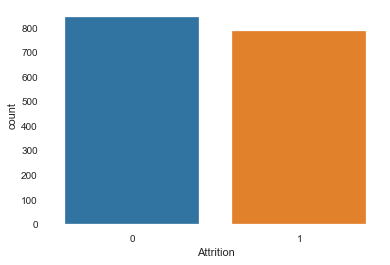

In [283]:
sns.countplot(df_y.Attrition)

In [284]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
#df_X_final = df_X_final.values
#df_y = df_y.values
X_train,X_test,y_train,y_test = train_test_split(df_X_final, df_y, test_size=0.10, random_state = 0, stratify=df_y)

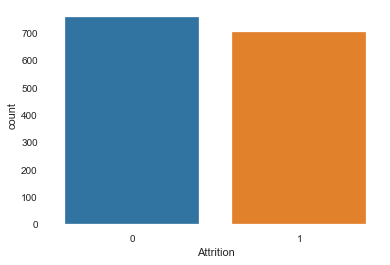

In [285]:
sns.countplot(y_train.Attrition)

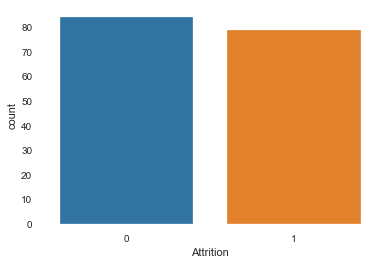

In [286]:
sns.countplot(y_test.Attrition)

In [287]:
X_train,X_test,y_train,y_test = X_train.values,X_test.values,y_train.values,y_test.values

In [288]:
from imblearn.over_sampling import SMOTE
oversampler=SMOTE(random_state=11, k_neighbors= 3)
X_train, y_train = oversampler.fit_sample(X_train,y_train)

In [289]:
y_train, y_test = y_train.ravel(), y_test.ravel()

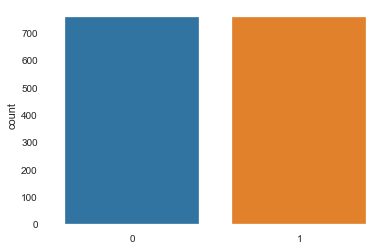

In [290]:
sns.countplot(y_train)

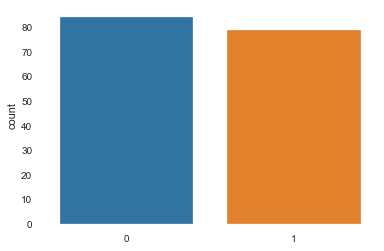

In [291]:
sns.countplot(y_test)

In [292]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn import metrics

In [293]:
def check_model_perf(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    print(model.__class__)
    print('-'*50)
    print("True Possitives  :\t{}\nTrue Negatives   :\t{}\nFalse Possitives :\t{}\nFalse Negatives  :\t{}".format(tp,tn,fp,fn))
    auc_score = metrics.roc_auc_score(y_test, predictions)
    print("AUC Score : {}".format(auc_score))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
    sns.lineplot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("Accuracy score: {}".format(metrics.accuracy_score(y_test, predictions)))
    print("="*80)
    print(metrics.classification_report(y_test, predictions))
    return auc_score

In [294]:
scores = dict()

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
--------------------------------------------------
True Possitives  :	79
True Negatives   :	81
False Possitives :	3
False Negatives  :	0
AUC Score : 0.9821428571428572
Accuracy score: 0.9815950920245399
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        84
           1       0.96      1.00      0.98        79

    accuracy                           0.98       163
   macro avg       0.98      0.98      0.98       163
weighted avg       0.98      0.98      0.98       163



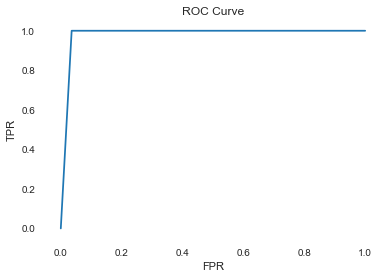

In [308]:
scores['Random Forest'] = check_model_perf(RandomForestClassifier(n_estimators=600, oob_score=True, max_features=0.4, criterion="entropy"), X_train, y_train, X_test, y_test)

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
--------------------------------------------------
True Possitives  :	79
True Negatives   :	78
False Possitives :	6
False Negatives  :	0
AUC Score : 0.9642857142857143
Accuracy score: 0.9631901840490797
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        84
           1       0.93      1.00      0.96        79

    accuracy                           0.96       163
   macro avg       0.96      0.96      0.96       163
weighted avg       0.97      0.96      0.96       163



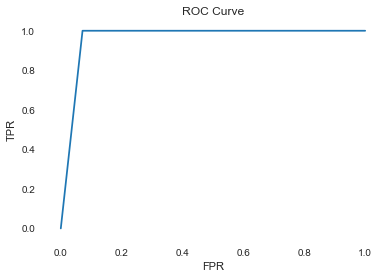

In [299]:
scores['Decision Tree'] = check_model_perf(DecisionTreeClassifier(criterion = 'gini', splitter = 'random'), X_train, y_train, X_test, y_test)

<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
--------------------------------------------------
True Possitives  :	58
True Negatives   :	71
False Possitives :	13
False Negatives  :	21
AUC Score : 0.7897076552139843
Accuracy score: 0.7914110429447853
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        84
           1       0.82      0.73      0.77        79

    accuracy                           0.79       163
   macro avg       0.79      0.79      0.79       163
weighted avg       0.79      0.79      0.79       163



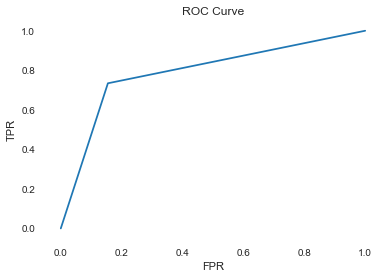

In [300]:
scores['AdaBoost'] = check_model_perf(AdaBoostClassifier(n_estimators=80, learning_rate=0.8), X_train, y_train, X_test, y_test)

In [301]:
pd.DataFrame.from_dict(scores, orient='index', columns=['AUC Score']).sort_values(by=['AUC Score'], ascending=False)

,AUC Score
Random Forest,0.988095
Decision Tree,0.964286
AdaBoost,0.789708


### Building A few Models with CV

In [302]:
from sklearn.model_selection import GridSearchCV

In [303]:
gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'n_estimators': [10, 20, 30, 40, 50,70,100,200,300,400,500,1000],
            'max_features': ['log2','auto','None']
        },
        cv=10, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'max_features': 'log2', 'n_estimators': 30}
0.9996666666666666


In [78]:
gsc = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid={
            'criterion': ['gini','entropy'],
            'splitter': ['best','random']
        },
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'criterion': 'gini', 'splitter': 'random'}
0.870242244684559


In [79]:
gsc = GridSearchCV(
        estimator=AdaBoostClassifier(),
        param_grid={
            'n_estimators': [20,40,50,60,80,100]
        },
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'n_estimators': 80}
0.959169307570949


In [146]:
from sklearn import tree

In [223]:
model = DecisionTreeClassifier(criterion = 'gini', splitter = 'random')
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

In [309]:
model = RandomForestClassifier(n_estimators=600, oob_score=True, max_features=0.4, criterion="entropy")
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=0.4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [310]:
pd.DataFrame(model.feature_importances_, index= final_cols).sort_values(by=0, ascending=False)

,0
MonthlyIncome,0.159880
EmployeeNumber,0.111087
DistanceFromHome,0.083882
PropCurrRoleCompYears,0.073719
OverTime_Yes,0.073503
PropCurrMgrCompYears,0.071026
PropWkngYrsToCompanies,0.055231
CommunicationSkill,0.051636
EnvironmentSatisfaction,0.049612
JobSatisfaction,0.047021


In [149]:
final_cols

array(['DistanceFromHome', 'EmployeeNumber', 'EnvironmentSatisfaction',
       'JobInvolvement', 'JobSatisfaction', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'CommunicationSkill',
       'PropWkngYrsToCompanies', 'PropCurrMgrCompYears',
       'PropCurrRoleCompYears', 'AgeCut', 'Stocks',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'Marita

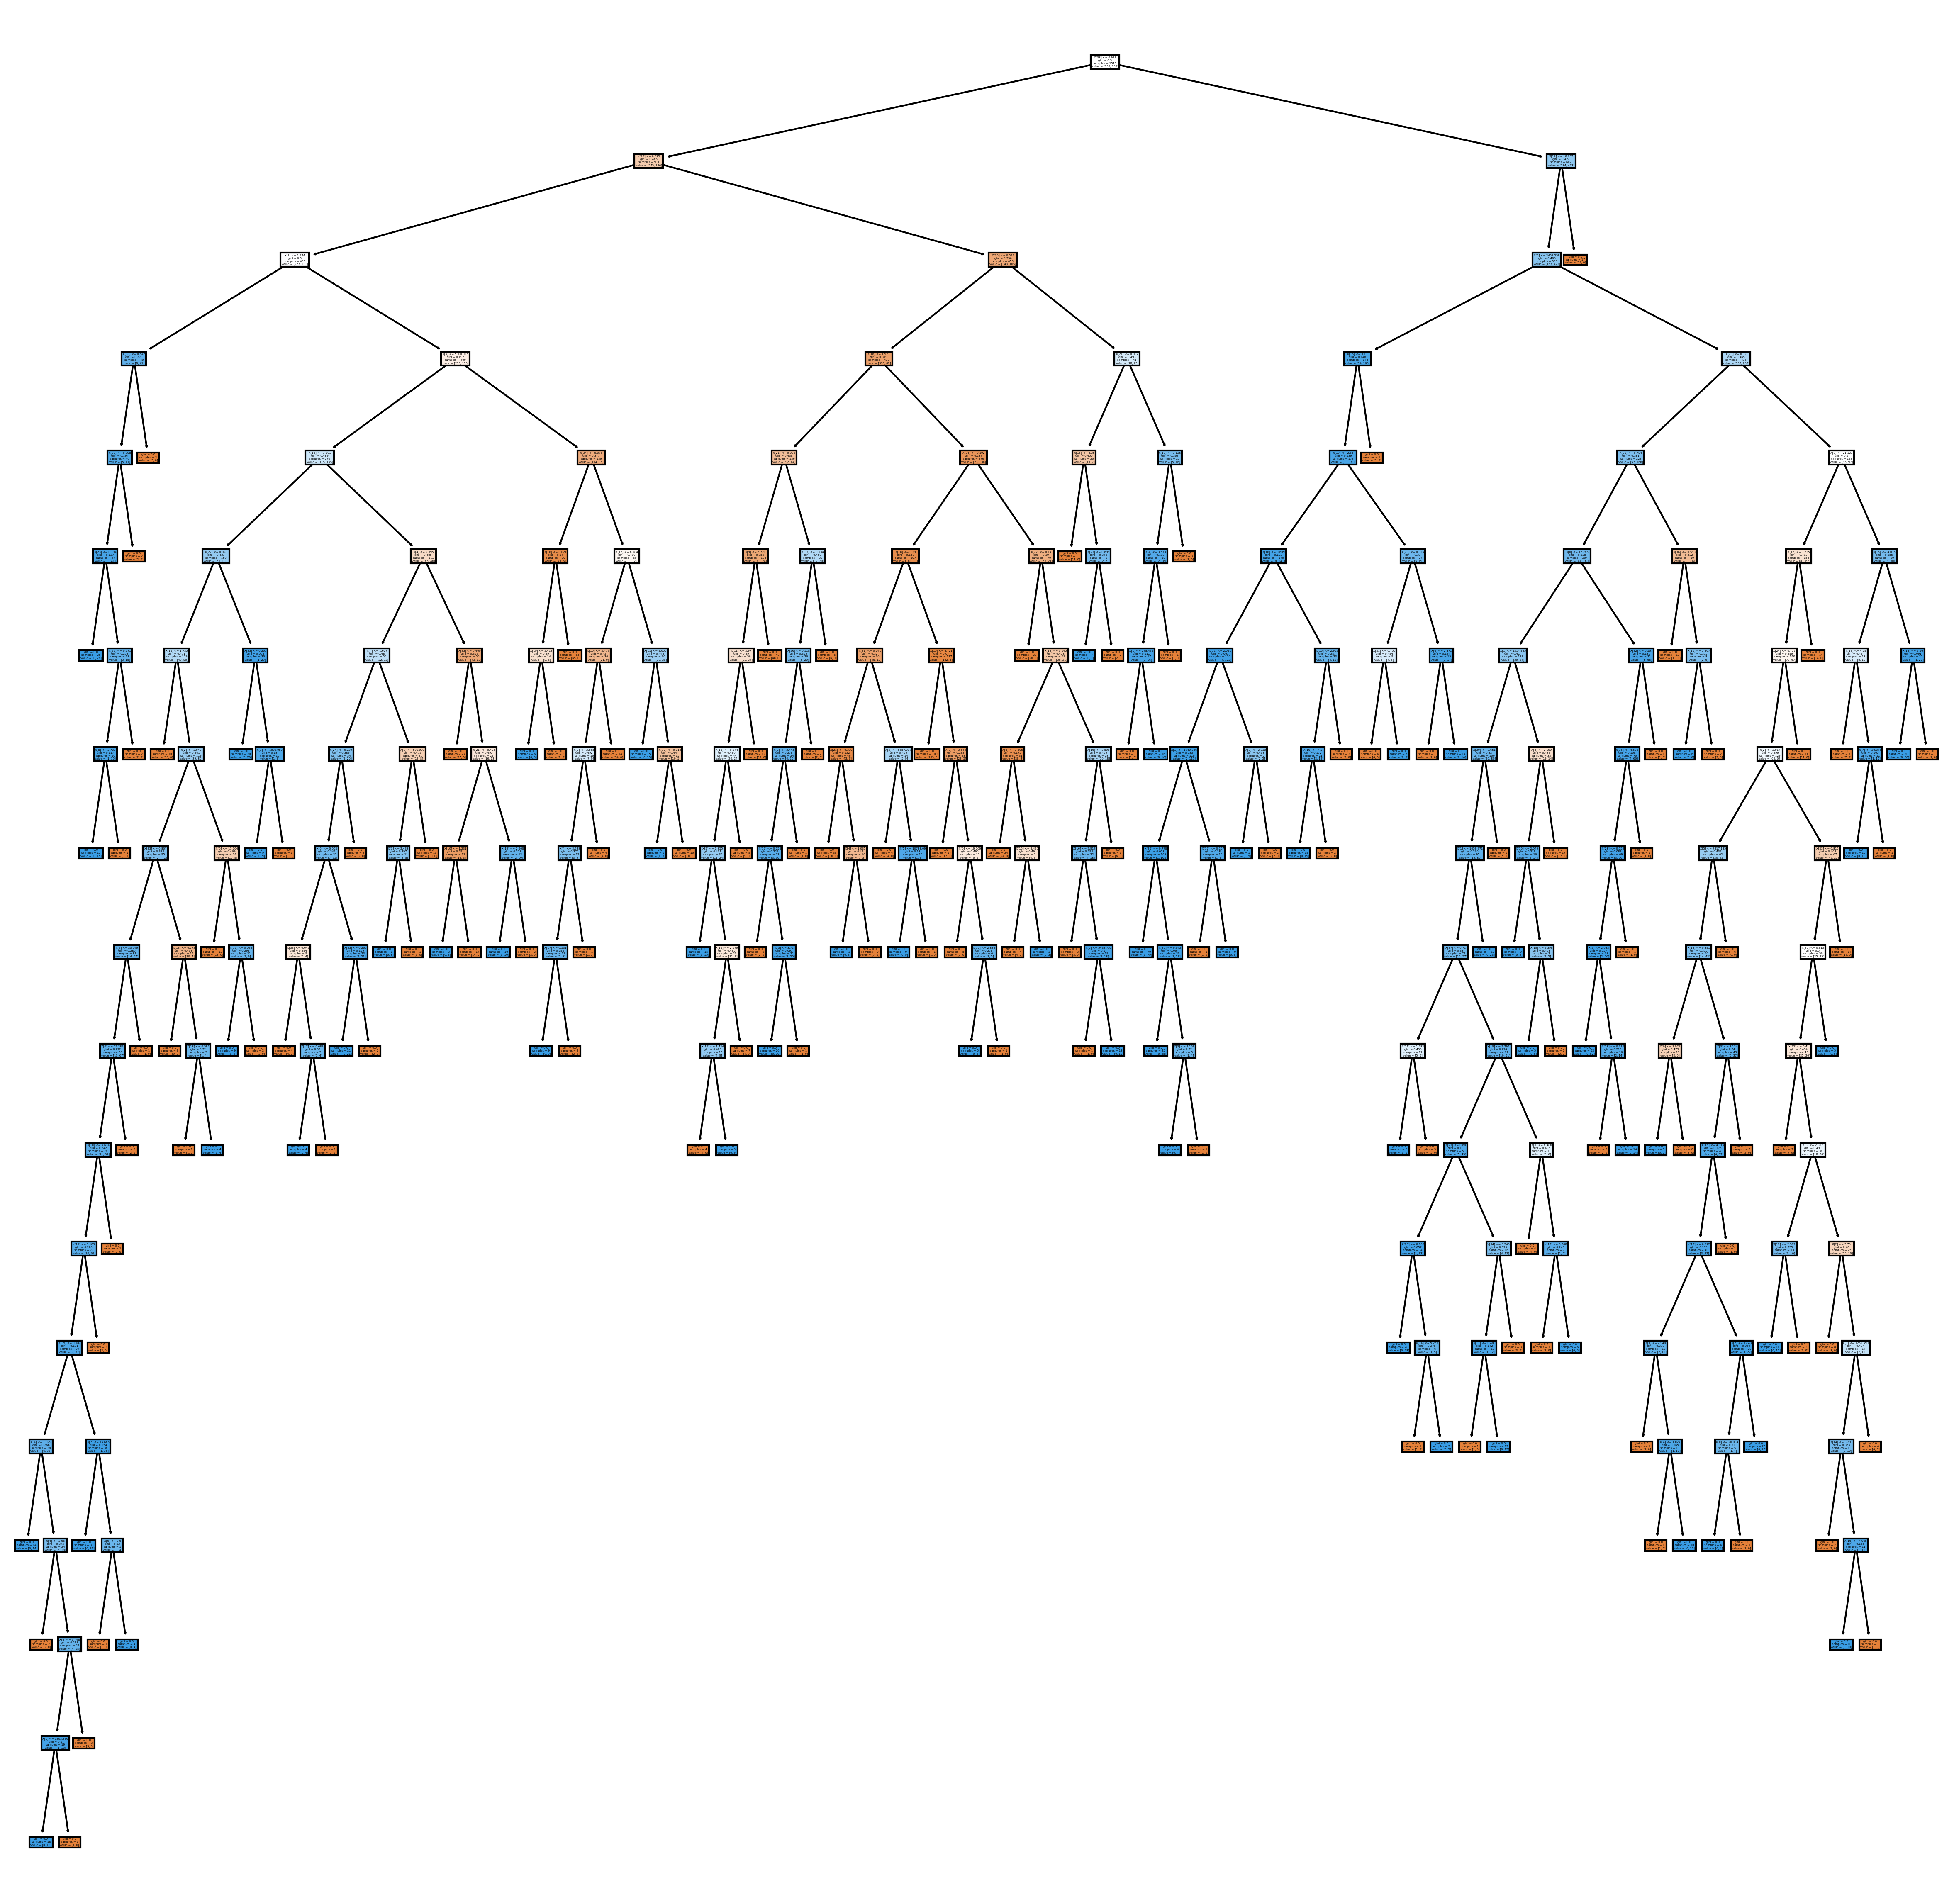

In [150]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=300)
tree.plot_tree(model,
               filled = True);
fig.savefig('imagename.png')

### Models_for_submission

In [151]:
!mkdir models

mkdir: models: File exists


RandomForest

In [311]:
X, y = oversampler.fit_resample(df_X_final, df_y)

In [312]:
model = RandomForestClassifier(n_estimators=600, oob_score=True, max_features=0.4, criterion="entropy")
model.fit(X_train, y_train)
pkl_filename = "models/RandomForestA.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [228]:
model = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', class_weight='balanced')
model.fit(X_train, y_train)
pkl_filename = "models/DecisionTreeA.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [157]:
model = AdaBoostClassifier(n_estimators=700, learning_rate=0.8)
model.fit(X_train, y_train)
pkl_filename = "models/AdaboostA.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)